# Setup

In [129]:
#! pip install pandas-datareader
#! pip install pmdarima
#! pip install plotly
!pip install dash-bootstrap-components
import numpy as np
from pandas_datareader import DataReader # pip install pandas-datareader
from pandas_datareader import data
from datetime import datetime
from pmdarima.arima import *
from pmdarima import preprocessing
from scipy import stats
from scipy.stats import skew

from statsmodels import api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import pmdarima as pm
import plotly.graph_objects as go
import plotly.express as px
 
start = pd.to_datetime('2010-01-01') # in YYYY-MM-DD format
end = pd.to_datetime('2018-01-01')
ts = data.DataReader('NDAQ', 'yahoo', start , end) # here 'yahoo' is the API to yahoo

train = ts.Close.loc['2010-01-01':'2017-12-01']
test_7 = ts.Close.loc['2017-12-20': '2018-01-01']
test_31 = ts.Close.loc['2017-11-15':'2018-01-01']
oos = ts.Close.loc['2017-12-02':'2018-01-01']

# Normalisation

In [23]:
ts.Close.skew()

0.4854340176287619

In [24]:
# put all normalisation functions before modelling

In [102]:
#transformed data
boxCoxData, boxCox_lambda = stats.boxcox(train)
boxCoxSkew = skew(boxCoxData)

#we want to compare their absolute skewness 
if(boxCoxSkew < 0):
    boxCoxSkew = boxCoxSkew * -1

johnsonData, johnson_lambda = stats.yeojohnson(train)
johnsonSkew = skew(johnsonData)

if(johnsonSkew < 0):
    johnsonSkew = johnsonSkew * -1

#to show which is less skewed 
print(johnsonSkew)
print(boxCoxSkew)

0.04629664317534893
0.042386389361065833


In [103]:
#so we know what method was used, so we can reverse later. 
normaliseMethod = "neither"

if(johnsonSkew < boxCoxSkew):
    normalised_Data = johnsonData
    fitted_lambda = johnson_lambda
    normaliseMethod = "johnson"
    
#being == doesn't really matter same either way
elif(boxCoxSkew <= johnsonSkew):
    normalised_Data = boxCoxData
    fitted_lambda = boxCox_lambda
    normaliseMethod = "boxcox"

skew(normalised_Data)
#print(fitted_lambda)

0.042386389361065833

In [69]:
actual = px.line(train, x=ts.index, y="Close", title="NASDAQ Closing Values: 2010 - 2018")
actual.show()

actual_hist = px.histogram(ts, title="Normal Distribution", x="Close", width=800, height=500)
actual_hist.show()

bc = pd.DataFrame(normalised_Data, columns = ['Close'])
bc = px.histogram(bc, x="Close")
bc.show()

# Modelling Functions

## Stationarity Tests:

In [28]:
def testLevelStationarity(ts):
    adf_result = sm.tsa.stattools.adfuller(ts)
    kpps_result = sm.tsa.stattools.kpss(ts)
    print(f'ADF p-value: {adf_result[1]}')
    print(f'KPPS p-value: {kpps_result[1]}')

    d = ndiffs(ts, test='kpss')
    d += ndiffs(ts, test='adf')
    d += ndiffs(ts, test='pp')
    
    return int(d/3)

In [29]:
testLevelStationarity(train)

ADF p-value: 0.9761703017966868
KPPS p-value: 0.01


/Users/oisintong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/Users/oisintong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




1

## Seasonal Tests:

In [13]:
def seasonal_tests(data):
     
    result1 = pm.arima.nsdiffs(data, m=3, max_D=30, test='ch')
    
    print("CH results: " + str(result1))
    
    result2 = pm.arima.nsdiffs(data, m=3, max_D=30, test='ocsb')
    
    print("OCSB results: " + str(result2))
    
    return int((result1+result2)/2)


In [14]:
seasonal_tests(normalised_Data)

CH results: 0
OCSB results: 0


0

## Lag Period:

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame (diff,columns=['Difference'])

In [ ]:
def find_lag_period(data):
    
    fig = px.line(ts.Close, x=[ts.Close.index], y="Close")
    fig.add_vline(x='2010-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2011-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2012-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2013-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2014-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2015-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2016-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2017-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2018-01-01', line_width=3, line_dash="dash", line_color="green")
    fig.show()
    
    adf_test = ADFTest(alpha = 0.05)
    
    test = list()
    lags = [365, 182, 90, 30, 14]
    
    # original data
    test.append(adf_test.should_diff(data))
    print(test[0])
    
    # year lag
    test.append(adf_test.should_diff(difference(data, 365)))
    print(test[1])
    
    # six months lag
    test.append(adf_test.should_diff(difference(data, 182))) 
    print(test[2])
    
    # three months lag 
    test.append(adf_test.should_diff(difference(data, 90)))
    print(test[3])
    
    # one month lag 
    test.append(adf_test.should_diff(difference(data, 30)))
    print(test[4])
    
    # fortnight lag
    test.append(adf_test.should_diff(difference(data, 14))) 
    print(test[5])
    
    # finds the first lag that doesn't need to be differenced
    for i in range(6):
        if (test[i][1] == False):
            return int(lags[i])
        
    return -1

In [ ]:
print(find_lag_period(normalised_Data))
print(find_lag_period(ts.Close))

## AR & MA Tests

In [30]:
def getAicBicHqic(dataset, arimaOrder, seasonalOrder):
    
    try:
        model = sm.tsa.statespace.SARIMAX(dataset, order = arimaOrder, seasonal_order=seasonalOrder).fit(disp=False)

        aic = model.aic
        bic = model.bic
        hqic = model.hqic
        
    
    except:
        pass
    
    return aic, bic, hqic

In [31]:
def evaluateSarimaModels(dataset, pVals, dVal, qVals, seasonalPVals, seasonalDval, seasonalQVals, m):
    
    L = []
    for p in pVals:
        for q in qVals:
            for seasonalP in seasonalPVals:
                for seasonalQ in seasonalQVals:
                    try:
                        order=(p,dVal,q)
                        seasonalOrder = (seasonalP, seasonalDval, seasonalQ, m)
                        
                        model = sm.tsa.statespace.SARIMAX(dataset, order = order, seasonal_order=seasonalOrder).fit(disp=False)

                        data = [[model, (p,dVal,q), (seasonalP, seasonalDval, seasonalQ, m), model.aic, model.bic, model.hqic, model.mse, model.test_heteroskedasticity(None)[0][0]]]
                        dd = pd.DataFrame(data = data, columns = ['model','Order', 'SeasonalOrder', 'Aic', 'Bic', 'Hqic', 'Mse', 'heteroskedasticity'])
                        L.append(dd)
                    except:
                        continue
    df = pd.concat(L, ignore_index=True)
    return df



In [104]:
df = evaluateSarimaModels(normalised_Data, [0,1], 1, [0,1], [0,1], 1, [0,1], 7)


/Users/oisintong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/oisintong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/oisintong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [105]:
df_johnson = evaluateSarimaModels(johnsonData, [0,1], 1, [0,1], [0,1], 1, [0,1], 7)

/Users/oisintong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/oisintong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/oisintong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [34]:
def sarima_model (data):
#train_test_split

    
    stepwise_model_7 = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    
    return stepwise_model_7

In [35]:
orig_model_7 = sarima_model(ts.Close)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=4795.849, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=4275.548, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.01 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=4793.468, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=4009.461, Time=0.49 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.79 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.67 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=4013.685, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=4008.358, Time=0.51 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=4274.611, Time=0.35 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=3.32 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.83 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=4010.353, Time=0.65 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=4010.334, Time=0.65 s

In [194]:
orig_pred = orig_model_7.predict_in_sample(start=1, ends=len(train))

In [90]:
#reverse
#restored_Data = (normalised_future_forecast*fitted_lambda +1)**(1/fitted_lambda)

In [62]:
#evaluation of model fit
#boxljung test
#model_df is p+q
#m is seasonal period
#change boxpierce to true if you want to also run that test
#lbVal is the Ljung-Box test statistic and pVal is its p value
def getBoxLjung(data, lags, model_df, m):
    #demean the data
    demeanedData = data.sub(data.mean())
    lbVal, pVal = statsmodels.stats.diagnostic.acorr_ljungbox(demeanedData, lags, boxpierce = False, model_df = model_df, period = m)
    
    return lbVal, pVal
    

In [ ]:
#Pass a fitted model
#returns 
#JBVal = Jarque-Bera test statistic
#JBPVal = pvalue of the test statistic
def getJarqueBera(data):
    
    JBVal, JBPVal, skewness, kurtosis = statsmodels.stats.stattools.jarque_bera(data.resid)
    
    return JBVal, JBPVal, skewness, kurtosis

## Function to sort different models:


In [106]:
import csv
import statsmodels

#input is a dataframe full of models
#I assume that there is no column that represents the skewness of model
def add_skewness(df, dataset):
    skewness = []
    #loop to get summary table of every model, then get skewness
    
    #To iterate through the df and isolate the model
    len = df.index
    for i in len:

        summary_table = df.model[i].summary()

        table_csv = summary_table.as_csv();

        skewness.append(table_csv[table_csv.find('Skew')+20 : table_csv.find('Skew')+25])


        #reader object stores all data
#         reader = csv.reader(table_csv)
        #change to finds out what cell skewness is in
#         skewness.append(table_csv[11][3])
        i+=1
    #at this point, skewness array should be full
    df['skewness'] = skewness
    return df;


In [107]:
add_skewness(df,train)
add_skewness(df_johnson,train)

,model,Order,SeasonalOrder,Aic,Bic,Hqic,Mse,heteroskedasticity,skewness
0,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 0, 7)",-12665.710611,-12660.116733,-12663.655926,0.003177,0.226858,-0.09
1,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 7)",-14004.928865,-13993.741109,-14000.819495,0.003129,0.225069,-0.10
2,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 7)",-13213.532376,-13202.344621,-13209.423007,0.003153,0.238227,-0.05
3,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 7)",-14002.935437,-13986.153803,-13996.771383,0.003129,0.225177,-0.10
4,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 0, 7)",-12689.945020,-12678.757264,-12685.835650,0.003176,0.233618,-0.07
5,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 7)",-14029.373796,-14012.592163,-14023.209742,0.003128,0.229242,-0.21
6,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(1, 1, 0, 7)",-13235.434018,-13218.652385,-13229.269964,0.003152,0.242544,-0.08
7,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(1, 1, 1, 7)",-14027.363900,-14004.988388,-14019.145161,0.003128,0.229135,-0.20
8,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 0, 7)",-12692.668748,-12681.480992,-12688.559378,0.003176,0.235316,-0.06
9,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 7)",-14030.625836,-14013.844202,-14024.461782,0.003128,0.230176,-0.21


## Graphing some models:

In [ ]:
# graphing 
def graphing(data, df):
    
    fig = px.line(data, x=ts.Close.index, y=[0])
    fig.data[0].line.color = 'rgb(0, 0, 0)'
    fig.data[0].name = "Original Data"
    fig.add_scatter
    
    fig.show()
    
    for i in range(6):
        model = sm.tsa.statespace.SARIMAX(normalised_Data, order = df['Order'][i], seasonal_order=df['SeasonalOrder'][i]).fit(disp=True)
        model = model.predict()
        fig = px.line(model, x=ts.Close.index, y=[0])
        fig.data[0].line.color = 'rgb(0, 0, 0)'
        fig.add_scatter
    
        fig.show()

In [ ]:
graphing(normalised_Data, df)

In [39]:
model_i = [5,7,9]
model_i = df.shape[0]
print(model_i)

16


Predicted Vals of 0 : 
 [ 1.         20.23999977 20.29999924 ... 78.31924046 79.53889655
 79.52242905]
78.00065216199643

 Conf int: 
 [[-2771.80764879  2771.80764879]
 [-1957.6994522   1962.22851713]
 [-1957.69782367  1962.23014566]
 ...
 [    2.89544089     2.93967464]
 [    2.90193145     2.94616519]
 [    2.90184461     2.94607836]] 



 Std Err: 
 [1.41421356e+03 1.00000000e+03 1.00000000e+03 ... 1.12843259e-02
 1.12843259e-02 1.12843259e-02] 



 RMSE: 
 34.08374837152808 


NEW BEST
Predicted Vals of 1 : 
 [ 1.         20.23999977 20.29999924 ... 78.33567185 79.20336996
 79.2014906 ]
77.67881455150683

 Conf int: 
 [[-2771.80764878  2771.80764878]
 [-1957.69945218  1962.22851712]
 [-1957.69782365  1962.23014565]
 ...
 [    2.90071944     2.93457258]
 [    2.90534816     2.9392013 ]
 [    2.9053382      2.93919134]] 



 Std Err: 
 [1.41421356e+03 1.00000000e+03 1.00000000e+03 ... 8.63616323e-03
 8.63616323e-03 8.63616323e-03] 



 RMSE: 
 33.81690227756842 


NEW BEST
Predicted 

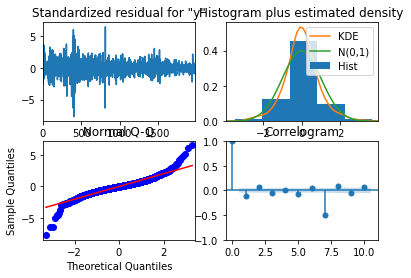

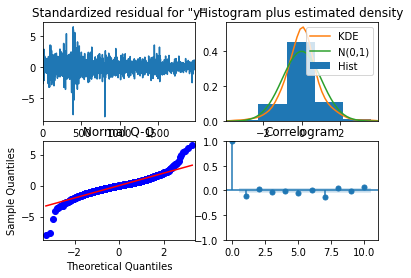

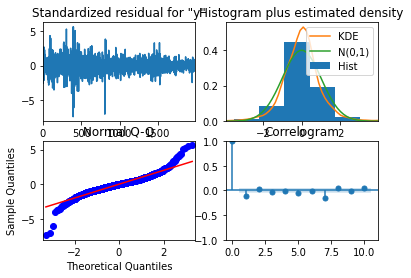

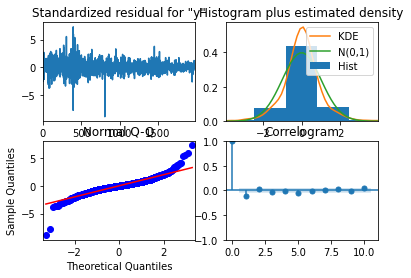

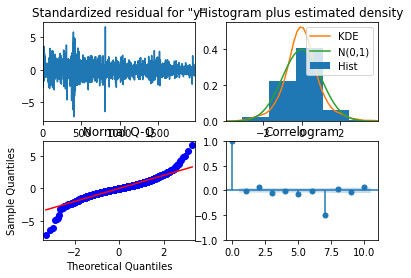

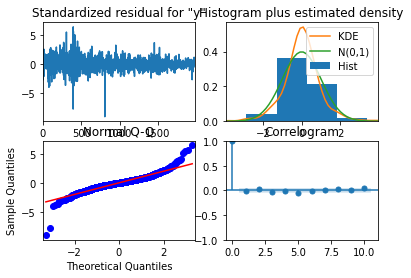

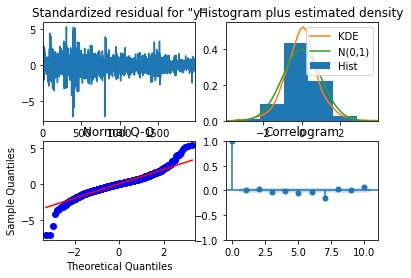

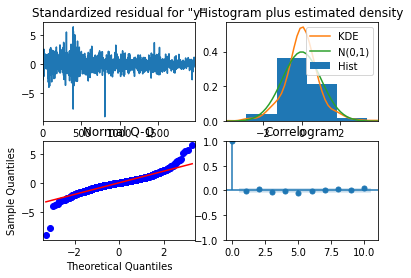

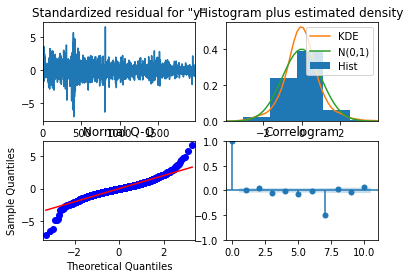

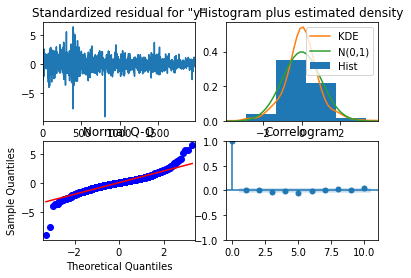

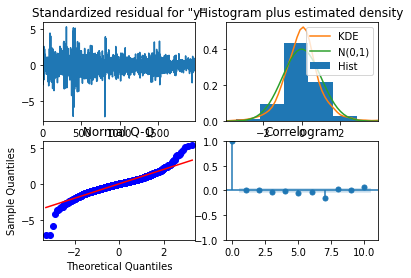

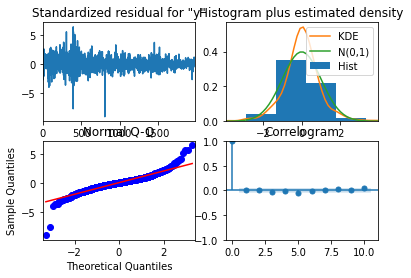

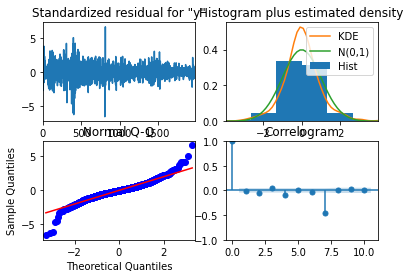

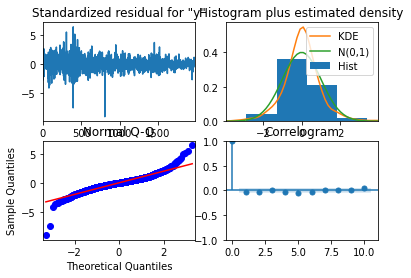

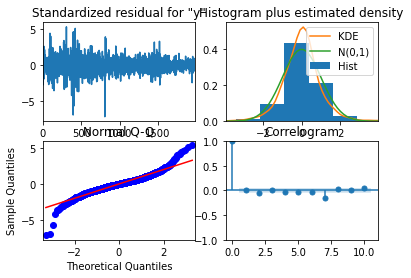

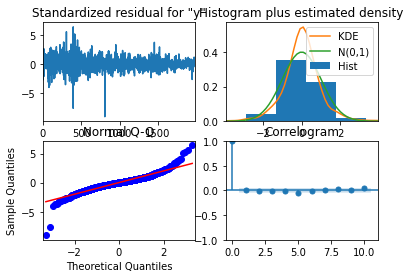

In [198]:
fig_7 = px.line(test_7, x=test_7.index, y=test_7)
fig_7.data = []
fig_31 = px.line(test_31, x=test_31.index, y=test_31)

best_rmse_7 = 100
best_rmse_7_johnson = 1000000
best_rmse_31 = 100
preds = [None] * 3
diag = []
for x in range(model_i):
    
    model = df.model[x]
    diag = model.plot_diagnostics()
    model_johnson = df_johnson.model[x]
    
    pred_7 = model.get_prediction(start=0, end=len(train)-1)
    pred_7_johnson = model_johnson.get_prediction(start=0, end=len(train)-1)
    pred_31 = model.get_prediction(start=0, end=len(train)-1)

    pred_7.predicted_mean = (pred_7.predicted_mean*fitted_lambda +1)**(1/fitted_lambda)
    pred_7_johnson.predicted_mean = (((johnson_lambda*pred_7_johnson.predicted_mean)+1)**(1/johnson_lambda)) - 1
    pred_31.predicted_mean = (pred_31.predicted_mean*fitted_lambda +1)**(1/fitted_lambda)

    print("Predicted Vals of", x, ": \n", pred_7.predicted_mean)
    #print(model.summary_frame(alpha=0.05))   //mean isn't updated to reversed vals
    #conf_int = (model.conf_int(0.5)*fitted_lambda +1)**(1/fitted_lambda)   //don't think we should be reveresing the conf_int
    conf_int = (pred_7.conf_int(0.5))
    se = (pred_7.se_mean)
    rmse_7 = sm.tools.eval_measures.mse(train, pred_7.predicted_mean)
    rmse_7_johnson = sm.tools.eval_measures.mse(train, pred_7_johnson.predicted_mean)
    print(rmse_7_johnson)
    rmse_31 = sm.tools.eval_measures.mse((train), pred_31.predicted_mean)

    print('\n',"Conf int: \n",conf_int,'\n\n')
    print('\n',"Std Err: \n",se,'\n\n')
    print('\n',"RMSE: \n",rmse_7,'\n\n')

    if(rmse_7 < best_rmse_7):
        print("NEW BEST")
        best_rmse_7 = rmse_7
        preds[0] = pred_7.predicted_mean
    if(rmse_7_johnson < best_rmse_7_johnson):
        best_rmse_7_johnson = rmse_7_johnson
        preds[1] = pred_7_johnson.predicted_mean
        
#     if(rmse_31 < best_rmse_31):
#         fig_31.data = [fig_31.data[0]] #clear other traces
#         fig_31.add_scatter(x=test_31.index, y=pred_31.predicted_mean,
#             name='('+', '.join(str(e) for e in df.Order[x])+')'+' ('+', '.join(str(e) for e in df.SeasonalOrder[x])+')', mode='lines')

fig_7.add_scatter(x=train.index, y=train, name="Actual Values", mode='lines')
fig_7.add_scatter(x=train.index, y=preds[0], name="Box-Cox Predicted", mode='lines')
fig_7.add_scatter(x=train.index, y=preds[1], name="Yeo-Johnson Predicted", mode='lines')
fig_7.add_scatter(x=train.index, y=orig_pred, name="Non-Transformed Predicted", mode='lines')

#rmse_7_orig = sm.tools.eval_measures.mse(ts.Close, orig_pred)

print(rmse_7)
#print(rmse_7_orig)

In [148]:
fig_7.show()
fig_31.show()

## Dash App

In [166]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

from pandas_datareader import DataReader # pip install pandas-datareader
from pandas_datareader import data

import pandas as pd
import pmdarima as pm
import plotly.graph_objects as go
import plotly.express as px


In [167]:
#set up app

app = dash.Dash()

In [168]:
#import datasets, for example;

start = pd.to_datetime('2010-01-01') # in YYYY-MM-DD format
end = pd.to_datetime('2018-01-01')
st = data.DataReader('NDAQ', 'yahoo', start , end) 


In [169]:
# dropdown options (currently runs through NASDAQ paramteres, should be changed to relevant parameters)

features = st.columns[1:-1]
opts = [{'label' : i, 'value' : i} for i in features]

# range slider options

st['High'] = pd.to_datetime(st.High)
dates = ['2015-02-17', '2015-05-17', '2015-08-17', '2015-11-17',
         '2016-02-17', '2016-05-17', '2016-08-17', '2016-11-17', '2017-02-17']


In [180]:
# create desired plotly figure (see https://images.plot.ly/plotly-documentation/images/python_cheat_sheet.pdf)

trace_1 = go.Scatter(x = st.Close, y = st['Close'],
                    name = 'Close',
                    line = dict(width = 2,
                                color = 'rgb(229, 151, 50)'))
layout = go.Layout(title = 'Time Series Plot',
                   hovermode = 'closest')
fig = go.Figure(data = [trace_1], layout = layout)

In [202]:
# create a Dash layout
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container(dbc.Jumbotron(
    [
        html.H1("Time Series Analysis on Stocks Prediction", className="display-3"),
        html.P(
            "Group 40 ",
            className="lead",
        ),
        html.Hr(className="my-2"),
        html.P(
            "Lorem ipsum."
        ),
        dcc.Graph(id = 'actual', figure = actual),
        dcc.Graph(id = 'pred_7', figure = fig_7),
        dcc.Graph(id = 'diag', figure = diag),
    ]
))


In [ ]:
#run server

app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
